# Extracting data from MISP using PyMISP

## Recovering the API KEY

- Go to `Global Actions` then `My Profile`
- Access the `/users/view/me` URL

In [491]:
from pymisp import PyMISP
import urllib3
urllib3.disable_warnings()

misp_url = 'https://localhost:8443/'
misp_key = 'GqfuZo444EFlylND0XaKZsEXgWgkPgguUZ6KVRuq'
# Should PyMISP verify the MISP certificate
misp_verifycert = False

misp = PyMISP(misp_url, misp_key, misp_verifycert)

In [492]:
import datetime
from pprint import pprint
import base64
import subprocess

## Retreiving an Event

In [493]:
r1 = misp.get_event('7907c4a9-a15c-4c60-a1b4-1d214cf8cf41', pythonify=True)
print(r1)
r2 = misp.get_event(2, pythonify=False)
print(type(r2))

<MISPEvent(info=Test PUSH filtering type)
<class 'dict'>


## Searching the Event index

In [494]:
r = misp.search_index(pythonify=True)
print(r[1].uuid)

7907c4a9-a15c-4c60-a1b4-1d214cf8cf41


#### Only published Events

In [495]:
r = misp.search_index(published=True, pythonify=True)
print(r)
# print(r[0].to_dict())

[<MISPEvent(info=Test 43214324), <MISPEvent(info=Test enrichment via WF), <MISPEvent(info=Big event), <MISPEvent(info=Small event)]


#### Playing with time

**Multiple type of timestamps for Events**
- `timestamp`: Timestamp of the **last modification** of the Event or its content (include Attributes, Objects, Tags, ...)
- `published_timestamp`: Timestamp of the **last publication** of the Event
- To generate report, you usually want to use `publish_timestamp`

**Multiple type of dates for Events**
- `date_from`: Only events having a more recent date will be returned
- `date_to`: Only events having an older date will be returned
- Both can be used at once to specify a time window


In [496]:
# Using string literal
sinceLastMonth = '30d'
# Using Python's datetime
sinceLastMonth = datetime.date.today() - datetime.timedelta(days=30)

r = misp.search_index(published=True, publish_timestamp=sinceLastMonth, pythonify=True)
print(r)

[<MISPEvent(info=Test 43214324), <MISPEvent(info=Test enrichment via WF)]


#### Data returned
- Searching the index will only returns high-level information about the Event and its attached context

- Can be useful for:
    - Statistics about number of created Event
    - Statistics about Organisation creating Event over time
    - Statistics about distribution level usage
- And, **If Event correctly contextualized**
    - Statistics about **type of incident**
    - Adversary tactics and techniques with **MITRE ATT&CK** usage
    - Malware familly

In [497]:
event = r[0].to_dict()
event_properties = event.keys()
print('# Event properties')
print(list(event_properties))

print('\n # Event Tags ({0})'.format(len(event['EventTag'])))
pprint(event['EventTag'][0])

print('\n # Event Clusters ({0})'.format(len(event['GalaxyCluster'])))

# Event properties
['uuid', 'info', 'distribution', 'threat_level_id', 'analysis', 'published', 'date', 'id', 'orgc_id', 'org_id', 'timestamp', 'publish_timestamp', 'sighting_timestamp', 'sharing_group_id', 'Org', 'Orgc', 'attribute_count', 'proposal_email_lock', 'locked', 'disable_correlation', 'extends_uuid', 'GalaxyCluster', 'EventTag']

 # Event Tags (12)
{'Tag': {'colour': '#326300',
         'id': '29',
         'is_galaxy': False,
         'name': 'circl:incident-classification="phishing"'},
 'event_id': '18',
 'id': '69',
 'local': False,
 'relationship_type': '',
 'tag_id': '29'}

 # Event Clusters (11)


#### Useful parameters

- `attribute` (Optional[str]) *Filter events on attribute's value*
- `published` (Optional[bool])
- `hasproposal` (Optional[bool])
- `eventid` (Optional[str, int])
- `tags` (Optional[str, List[str]])
- `date_from` (Optional[datetime, date, int, str, float, None])
- `date_to` (Optional[datetime, date, int, str, float, None])
- `eventinfo` (Optional[str])
- `threatlevel` (Optional[str, int])
- `analysis` (Optional[str, int])
- `distribution` (Optional[str, int])
- `sharinggroup` (Optional[str, int])
- `org` (Optional[str, List[[str, int]])
- `timestamp` (Optional[datetime, date, int, str, float, None, List[[datetime, date, int, str, float, None], [datetime, date, int, str, float, None]]])
    - timestamp=(datetime.today() - timedelta(days=1))
    - timestamp=['14d', '7d']
    - timestamp=int(datetime.today().timestamp())
- `publish_timestamp` (Optional[datetime, date, int, str, float, None, List[[datetime, date, int, str, float, None], [datetime, date, int, str, float, None]]])

## Retreiving data with RestSearch

The `RestSearch` endpoint can be used on multiple scopes. It has more filtering parameters and is generally flexible.

Supported scopes (also called Controllers): `events`, `attributes`, `objects`

### `/events/restSearch` VS `/attributes/restSearch`

- Both endpoints support most of the parameter
- They differs in the data returned
    - `/events/restSearch` returns the whole Event with its child elements (Attributes, Objects, Proposals, ..)
    - `/attributes/restSearch` returns all attributes

#### Getting only metadata: Do not include child elements (such as Attributes, ...)

In [498]:
r = misp.search(controller='events', metadata=True, pythonify=True)
print(r)

[<MISPEvent(info=Test), <MISPEvent(info=Test PUSH filtering type), <MISPEvent(info=Decaying example), <MISPEvent(info=Test tag filtering), <MISPEvent(info=Should not be pulled), <MISPEvent(info=Event report example), <MISPEvent(info=Wireshark test event), <MISPEvent(info=Test 4), <MISPEvent(info=Test 43214324), <MISPEvent(info=Test btc), <MISPEvent(info=Analysis of a Flubot malware captured by a honeypot), <MISPEvent(info=Test enrichment via WF), <MISPEvent(info=Test TLP replace), <MISPEvent(info=Test event for MM), <MISPEvent(info=Big event), <MISPEvent(info=test 77), <MISPEvent(info=Small event), <MISPEvent(info=Small event), <MISPEvent(info=Infection via spear-phishing email), <MISPEvent(info=test event TLPs), <MISPEvent(info=test), <MISPEvent(info=Test event ip|port -> ip-port), <MISPEvent(info=test bgp), <MISPEvent(info=test tlp:white and clear), <MISPEvent(info=Test)]


### Searching Attributes with RestSearch

#### Searching for values

In [499]:
r1 = misp.search(controller='attributes', value='8.8.8.8', pythonify=True)
print('Simple value:', r1)

r2 = misp.search(controller='attributes', value=['8.8.8.8', '5.4.2.1'], pythonify=True)
print('List of values:', r2)

r3 = misp.search(controller='attributes', value=['https://www.github.com/%'], pythonify=True)
print('Wildcard:', r3)

Simple value: [<MISPAttribute(type=ip-src, value=8.8.8.8), <MISPAttribute(type=ip-dst, value=8.8.8.8), <MISPAttribute(type=ip-dst|port, value=8.8.8.8|443)]
List of values: [<MISPAttribute(type=ip-src, value=5.4.2.1), <MISPAttribute(type=ip-src, value=8.8.8.8), <MISPAttribute(type=ip-dst, value=8.8.8.8), <MISPAttribute(type=ip-dst|port, value=8.8.8.8|443)]
Wildcard: [<MISPAttribute(type=url, value=https://www.github.com/stricaud)]


#### Searching for types

In [500]:
r1 = misp.search(controller='attributes', type_attribute='first-name', pythonify=True)
print(r1)

r2 = misp.search(controller='attributes', type_attribute=['malware-sample', 'attachment'], pythonify=True)
print(r2)

[<MISPAttribute(type=first-name, value=Sam), <MISPAttribute(type=first-name, value=NETRICSA), <MISPAttribute(type=first-name, value=Mental), <MISPAttribute(type=first-name, value=Andrew)]
[<MISPAttribute(type=attachment, value=SeriousSam.png), <MISPAttribute(type=attachment, value=mental.png), <MISPAttribute(type=attachment, value=EDF.png), <MISPAttribute(type=attachment, value=malicious.exe), <MISPAttribute(type=attachment, value=malicious.exe), <MISPAttribute(type=attachment, value=original.jpeg), <MISPAttribute(type=attachment, value=payload-1-8), <MISPAttribute(type=attachment, value=drawing.svg), <MISPAttribute(type=attachment, value=drawing.png), <MISPAttribute(type=attachment, value=Screenshot from 2021-10-19 16-31-56.png), <MISPAttribute(type=malware-sample, value=sample.apk|eff61f1bf7b14d261d5b421208d1bf68), <MISPAttribute(type=malware-sample, value=malware.exe|70f3bc193dfa56b78f3e6e4f800f701f)]


#### Searching for tags

In [501]:
r1 = misp.search(controller='attributes', tags='tlp:red', pythonify=True)
print('Simple tag:', len(r1))
print('\tFirst Attribute', r1[0].Tag)

r2 = misp.search(controller='attributes', tags=['PAP:RED', 'tlp:red'], pythonify=True)
print('List of tags:', len(r2))
print('\tThird Attribute', r2[2].Tag)

Simple tag: 9
	First Attribute [<MISPTag(name=tlp:red)>]
List of tags: 18
	Third Attribute [<MISPTag(name=PAP:RED)>, <MISPTag(name=adversary:infrastructure-type="exploit-distribution-point")>]


In [502]:
r3 = misp.search(controller='attributes', tags=['misp-galaxy:target-information=%'], pythonify=True)
print('Wildcard:', len(r3))
print('\tTags of all Attributes:', [attr.Tag for attr in r3])
print()
print(base64.b64decode('T3BlbiBxdWVzdGlvbjogV2h5IGRvIHdlIGhhdmUgQXR0cmlidXRlcyBkZXNwaXRlIHRoZW0gbm90IGhhdmluZyB0aGUgY29ycmVjdCB0YWcgYXR0YWNoZWQ/Cg==').decode())

Wildcard: 22
	Tags of all Attributes: [[], [], [], [], [], [], [], [], [], [], [], [], [<MISPTag(name=tlp:red)>], [], [], [], [], [], [], [], [], [<MISPTag(name=test_foo)>]]

Open question: Why do we have Attributes despite them not having the correct tag attached?



In [503]:
allEventTags = [
    [tag.name for tag in misp.get_event(attr.event_id, pythonify=True).Tag if tag.name.startswith('misp-galaxy:target-information=')]
    for attr in r3
]
allUniqueEventTag = set()
for tags in allEventTags:
    for tag in tags:
        allUniqueEventTag.add(tag)
print('All unique Event tags:', allUniqueEventTag)

All unique Event tags: {'misp-galaxy:target-information="Canada"', 'misp-galaxy:target-information="China"', 'misp-galaxy:target-information="Germany"', 'misp-galaxy:target-information="Luxembourg"'}


In [504]:
r4 = misp.search(
    controller='attributes',
    tags=['misp-galaxy:target-information=%', '!misp-galaxy:target-information="Luxembourg"'],
    pythonify=True)
print('Negation:', len(r4))


# Showing unique Event tags
allEventTags = [
    [tag.name for tag in misp.get_event(attr.event_id, pythonify=True).Tag if tag.name.startswith('misp-galaxy:target-information=')]
    for attr in r4
]
allUniqueEventTag = set()
for tags in allEventTags:
    for tag in tags:
        allUniqueEventTag.add(tag)
print('All unique Event tags:', allUniqueEventTag)

Negation: 17
All unique Event tags: {'misp-galaxy:target-information="Canada"', 'misp-galaxy:target-information="China"', 'misp-galaxy:target-information="Germany"'}


**Want to also have the Event tags included**?

In [505]:
r5 = misp.search(
    controller='attributes',
    tags='misp-galaxy:target-information=%',
    pythonify=True)
print('Tags of first attibute:', [tag.name for tag in r5[0].Tag])

r6 = misp.search(
    controller='attributes',
    tags='misp-galaxy:target-information=%',
    includeEventTags=True,
    pythonify=True)
print('Tags of first attibute:', [tag.name for tag in r6[0].Tag])

Tags of first attibute: []
Tags of first attibute: ['tlp:white', 'osint:lifetime="perpetual"', 'osint:certainty="50"', 'workflow:state="draft"', 'misp-galaxy:threat-actor="APT 29"', 'smo:sync', 'misp-galaxy:target-information="Canada"', 'misp-galaxy:target-information="China"', 'misp-galaxy:sector="Defense"', 'misp-galaxy:sector="Infrastructure"', 'misp-galaxy:malpedia="Kobalos"', 'misp-galaxy:mitre-attack-pattern="SSH - T1021.004"', 'misp-galaxy:mitre-attack-pattern="Software - T1592.002"']


**Complex query**

In [506]:
complex_query = misp.build_complex_query(or_parameters=['tlp:amber', 'adversary:infrastructure-type="c2"'])
r7 = misp.search(
    controller='attributes',
    tags=complex_query,
    includeEventTags=True,
    pythonify=True)
print('Or:', len(r7))
pprint([
    [tag.name for tag in attr.Tag if (tag.name == 'tlp:amber' or tag.name == 'adversary:infrastructure-type="c2"')] for attr in r7[:5]
])
print()

complex_query = misp.build_complex_query(and_parameters=['tlp:amber', 'adversary:infrastructure-type="c2"'])
r8 = misp.search(
    controller='attributes',
    tags=complex_query,
    includeEventTags=True,
    pythonify=True)
print('And:', len(r8))
pprint([
    [tag.name for tag in attr.Tag if (tag.name == 'tlp:amber' or tag.name == 'adversary:infrastructure-type="c2"')] for attr in r8
])

Or: 1056
[['tlp:amber'], ['tlp:amber'], ['tlp:amber'], ['tlp:amber'], ['tlp:amber']]

And: 5
[['adversary:infrastructure-type="c2"', 'tlp:amber'],
 ['adversary:infrastructure-type="c2"', 'tlp:amber'],
 ['adversary:infrastructure-type="c2"', 'tlp:amber'],
 ['adversary:infrastructure-type="c2"', 'tlp:amber'],
 ['adversary:infrastructure-type="c2"', 'tlp:amber']]


#### Searching on GalaxyCluster metadata

In [507]:
body = {
    'galaxy.member-of': 'NATO',
    'galaxy.official-languages': 'French',
}

events = misp.direct_call('/events/restSearch', body)
print('Events: ', len(events))
pprint([
    [tag['name'] for tag in event['Event']['Tag'] if tag['name'].startswith('misp-galaxy:target-information')] for event in events
])

Events:  2
[['misp-galaxy:target-information="Canada"',
  'misp-galaxy:target-information="China"'],
 ['misp-galaxy:target-information="Luxembourg"']]


- **Note 1**: The `galaxy.*` instructions are not supported by PyMISP
- **Note 2**: Each `galaxy.*` instructions are **AND**ed and are applied for the same cluster
    - Cannot combine from different clusters
    - Combining `Galaxy.official-languages` and `Galaxy.synonyms` would likely gives no result

#### Searching on creator Organisation metadata

In [508]:
all_orgs = misp.organisations()
print('Organisation nationality:', {org['Organisation']['name']: org['Organisation']['nationality'] for org in all_orgs})

body = {
    'org.nationality': ['Luxembourg'],
    'org.sector': ['financial'],
}

events = misp.direct_call('/events/restSearch', body)
print('Events: ', len(events))
print('Org for each Event:', [event['Event']['Orgc']['name'] for event in events])

Organisation nationality: {'admin_org': '', 'CIRCL': '', 'ORGNAME': '', 'Training': 'Luxembourg'}
Events:  4
Org for each Event: ['Training', 'Training', 'Training', 'Training']


- **Note 1**: The `org.*` instructions are not supported by PyMISP

#### ReturnFormat

**CSV**

In [509]:
r1 = misp.search(
    controller='attributes',
    type_attribute=['ip-src', 'ip-dst'],
    return_format='csv')
print(r1)

uuid,event_id,category,type,value,comment,to_ids,date,object_relation,attribute_tag,object_uuid,object_name,object_meta_category
"724d5417-41e6-40a5-b368-bdfbe652302a",2,"Network activity","ip-dst","4.3.2.1","Hello all!",0,1639127173,"","","","",""
"ba8e1a5a-6bb6-4ae5-9872-0a01b6b05cad",2,"Network activity","ip-dst","5.3.1.2","",1,1639060465,"ip","","","",""
"8c16cf20-d5bd-4ed3-b243-98c00c16e591",2,"Network activity","ip-dst","23.1.4.2","",1,1639126626,"ip","","","",""
"25a7bbb0-31f6-4525-94c0-89af86030201",16,"Network activity","ip-dst","127.0.0.1","",1,1645191487,"ip-dst","","","",""
"f3eb2f37-d08d-4dbb-be0c-346ac508693f",16,"Network activity","ip-dst","127.0.0.1","",1,1645191487,"ip-dst","","","",""
"f0a002d8-38a5-40f9-9a62-7e975cc8f987",16,"Network activity","ip-dst","127.0.0.1","",1,1645191487,"ip-dst","","","",""
"61bfb8e3-20e3-4f37-905d-9d4e14f2564a",20,"Network activity","ip-dst","8.231.77.176","",1,1665471239,"ip","PAP:RED,adversary:infrastructure-type=""exploit-distribution-p

**Aggregated context** with `context-markdown`, `context` and `attack`

In [510]:
# Get the context of Events that were created by organisations from the financial sector

body = {
    'returnFormat': 'context-markdown',
    'org.sector': ['financial'],
}

r2 = misp.direct_call('/events/restSearch', body)
print(r2)

# Aggregated context data
## Tags and Taxonomies
#### admiralty-scale
*The Admiralty Scale or Ranking (also called the NATO System) is used to rank the reliability of a source and the credibility of an information. Reference based on FM 2-22.3 (FM 34-52) HUMAN INTELLIGENCE COLLECTOR OPERATIONS and NATO documents.*
- <span class="tag-container"><span class="tag" style="background-color: #0eb100; color: white">admiralty-scale:information-credibility=&quot;1&quot;</span></span>

    - **information-credibility**: Information Credibility
    - **1**: Confirmed by other sources
- <span class="tag-container"><span class="tag" style="background-color: #0fc000; color: white">admiralty-scale:information-credibility=&quot;2&quot;</span></span>

    - **information-credibility**: Information Credibility
    - **2**: Probably true
- <span class="tag-container"><span class="tag" style="background-color: #054300; color: white">admiralty-scale:source-reliability=&quot;a&quot;</span></span>

    - **s

In [511]:
# Get the context of Events that had the threat actor APT-29 attached

body = {
    'returnFormat': 'context',
    'tags': ['misp-galaxy:threat-actor=\"APT 29\"'],
    'staticHtml': 1, # If you want a JS-free HTML
}

r2 = misp.direct_call('/events/restSearch', body)
with open('/tmp/attackOutput.html', 'w') as f:
    f.write(r2)
    # subprocess.run(['google-chrome', '--incognito', '/tmp/attackOutput.html'])


#### Be carefull with the amount of data you ask, use `pagination` if needed

- `limit`: Specify the amount of data to be returned
- `page`: Specify the start of the rolling window. Is **not** zero-indexed

If the size of the returned data is larger than the memory enveloppe you might get a different behavior based on your MISP setting:
- Nothing returned. Allowed memeory by PHP process exausted
- Data returned but slow. MISP will concatenante the returned data in a temporary file on disk
    - This behavior is only applicable for `/*/restSearch` endpoints

In [ ]:
r1 = misp.search(controller='attributes', pythonify=True)
print('Amount of Attributes', len(r1))

r2 = misp.search(
    controller='attributes',
    page=1,
    limit=5,
    pythonify=True)
print('Amount of paginated Attributes', len(r2))

## Searching for Sightings

In [513]:
body = {
    'last': '7d'
}

sightings = misp.direct_call('/sightings/restSearch', body)
pprint(sightings)

[{'Sighting': {'Organisation': {'id': '1',
                                'name': 'ORGNAME',
                                'uuid': 'c5de83b4-36ba-49d6-9530-2a315caeece6'},
               'attribute_id': '1441',
               'date_sighting': '1670924035',
               'event_id': '40',
               'id': '12',
               'org_id': '1',
               'source': '',
               'type': '0',
               'uuid': '65bd7539-29eb-46eb-bf7b-4c02473062c7',
               'value': '398324'}},
 {'Sighting': {'Organisation': {'id': '1',
                                'name': 'ORGNAME',
                                'uuid': 'c5de83b4-36ba-49d6-9530-2a315caeece6'},
               'attribute_id': '1441',
               'date_sighting': '1670924430',
               'event_id': '40',
               'id': '13',
               'org_id': '1',
               'source': '',
               'type': '0',
               'uuid': '10857410-0033-4457-8a1d-c8331ee55d72',
               'value': 

## Plotting data

#### Sightings over time

In [512]:
import pandas as pd
import matplotlib.pyplot as plt

In [514]:
# Converting our data to Panda DataFrame
sighting_rearranged = [sighting['Sighting'] for sighting in sightings]
df = pd.DataFrame.from_dict(sighting_rearranged)
df["date_sighting"] = pd.to_datetime(df["date_sighting"], unit='s')
df['one'] = 1
df

,id,attribute_id,event_id,org_id,date_sighting,uuid,source,type,value,Organisation,one
0,12,1441,40,1,2022-12-13 09:33:55,65bd7539-29eb-46eb-bf7b-4c02473062c7,,0,398324,"{'id': '1', 'uuid': 'c5de83b4-36ba-49d6-9530-2...",1
1,13,1441,40,1,2022-12-13 09:40:30,10857410-0033-4457-8a1d-c8331ee55d72,,0,398324,"{'id': '1', 'uuid': 'c5de83b4-36ba-49d6-9530-2...",1
2,14,1441,40,1,2022-12-13 09:40:54,1639fe60-0458-40f3-961b-7dc14eee9a7b,,1,398324,"{'id': '1', 'uuid': 'c5de83b4-36ba-49d6-9530-2...",1
3,15,1441,40,1,2022-12-13 09:40:55,ee54ec70-3597-4455-bce9-c889202d533e,,1,398324,"{'id': '1', 'uuid': 'c5de83b4-36ba-49d6-9530-2...",1
4,16,1441,40,1,2022-12-13 09:40:56,2c1cf4d1-a6ce-474b-8878-0251ee2b6bc5,,1,398324,"{'id': '1', 'uuid': 'c5de83b4-36ba-49d6-9530-2...",1
5,17,1448,41,1,2022-12-14 14:14:59,39dff1d2-7082-48a9-8d30-ce29d412879b,,0,testtest,"{'id': '1', 'uuid': 'c5de83b4-36ba-49d6-9530-2...",1
6,18,1448,41,1,2022-12-14 14:15:01,84a8e7d0-715b-453f-8cdb-07db0c208185,,0,testtest,"{'id': '1', 'uuid': 'c5de83b4-36ba-49d6-9530-2...",1
7,19,77,9,1,2022-12-14 14:15:07,264e4a25-e072-46e5-8460-b8df72e3115c,,0,5.4.2.1,"{'id': '1', 'uuid': 'c5de83b4-36ba-49d6-9530-2...",1
8,20,77,9,1,2022-12-14 14:15:08,b9f15aeb-54ea-44e5-90b8-22a418b973df,,0,5.4.2.1,"{'id': '1', 'uuid': 'c5de83b4-36ba-49d6-9530-2...",1
9,21,243,9,1,2022-12-14 14:15:09,4ef355f8-1cd3-476c-bccf-90a23b4eebfe,,0,test,"{'id': '1', 'uuid': 'c5de83b4-36ba-49d6-9530-2...",1


In [ ]:
print('Min and Max:', df['date_sighting'].min(), df['date_sighting'].max())
print('Time delta:', df['date_sighting'].max() - df['date_sighting'].min())
print('Unique Event IDs:', df.event_id.unique())

1441    6
1342    3
1448    2
77      2
243     1
Name: attribute_id, dtype: int64


<AxesSubplot: >

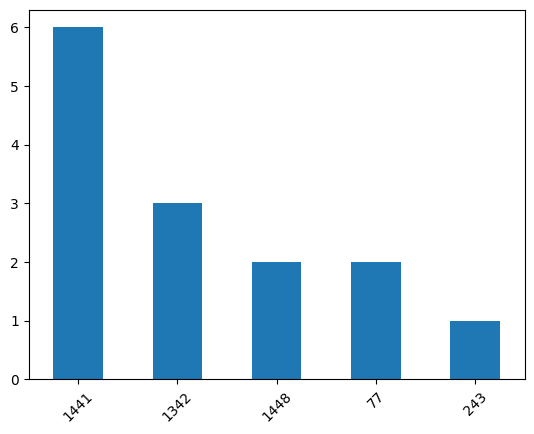

In [515]:
# Grouping by Attribute value
value_count = df['attribute_id'].value_counts()
print(value_count)
value_count.plot(kind='bar', rot=45)

2    9
1    5
Name: date_sighting, dtype: int64


<AxesSubplot: >

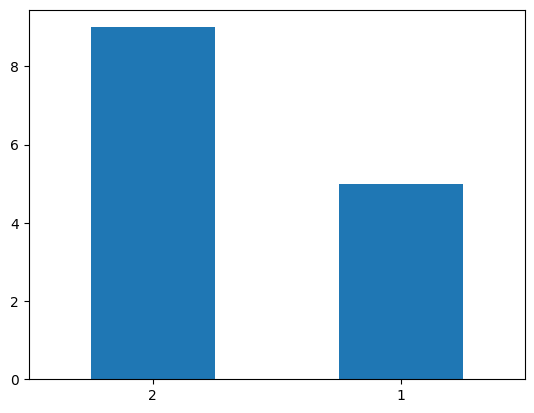

In [516]:
# Grouping by weekday (0-indexed)
amount_per_weekday = df['date_sighting'].dt.weekday.value_counts()
print(amount_per_weekday)
amount_per_weekday.plot(kind='bar', rot=0)

date_sighting
9     5
14    8
15    1
Name: one, dtype: int64


<AxesSubplot: xlabel='date_sighting'>

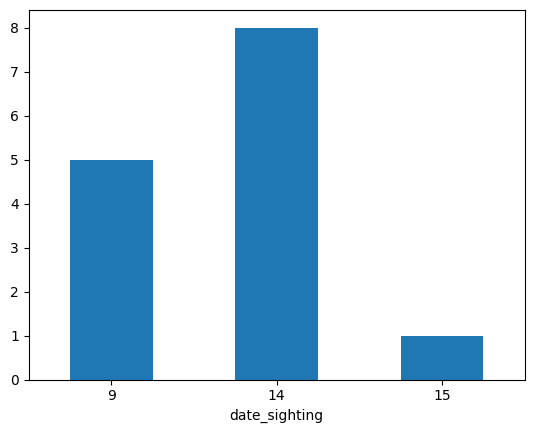

In [517]:
amount_per_weekday_for_each_attribute = df.groupby([df['date_sighting'].dt.hour])['one'].sum()
print(amount_per_weekday_for_each_attribute)
amount_per_weekday_for_each_attribute.plot(kind='bar', rot=0)